![Industrial Machinery](industrial-machine-level-3.jpg "industrial machine")

# Predicting Industrial Machine Downtime: Level 3

## 📖 Background
You work for a manufacturer of high-precision metal components used in aerospace, automotives, and medical device applications. Your company operates three different machines on its shop floor that produce different sized components, so minimizing the downtime of these machines is vital for meeting production deadlines.

Your team wants to use a data-driven approach to predicting machine downtime, so proactive maintenance can be planned rather than being reactive to machine failure. To support this, your company has been collecting operational data for over a year and whether each machine was down at those times.

In this third level, you're going to develop a predictive model that could be combined with real-time operational data to detect likely machine failure. This level is aimed towards advanced learners. If you want to challenge yourself a bit less, check out the other levels!

## 💾 The data

The company has stored the machine operating data in a single table, available in `'data/machine_downtime.csv'`.

#### Each row in the table represents the operational data for a single machine on a given day:
- `"Date"` - the date the reading was taken on.
- `"Machine_ID"` - the unique identifier of the machine being read.
- `"Assembly_Line_No"` - the unique identifier of the assembly line the machine is located on.
- `"Hydraulic_Pressure(bar)"`, `"Coolant_Pressure(bar)"`, and `"Air_System_Pressure(bar)"` - pressure measurements at different points in the machine.
- `"Coolant_Temperature"`, `"Hydraulic_Oil_Temperature"`, and `"Spindle_Bearing_Temperature"` - temperature measurements (in Celsius) at different points in the machine.
- `"Spindle_Vibration"`, `"Tool_Vibration"`, and `"Spindle_Speed(RPM)"` - vibration (measured in micrometers) and rotational speed measurements for the spindle and tool.
- `"Voltage(volts)"` - the voltage supplied to the machine.
- `"Torque(Nm)"` - the torque being generated by the machine.
- `"Cutting(KN)"` - the cutting force of the tool.
- `"Downtime"` - an indicator of whether the machine was down or not on the given day.

## Competition Goals 💪

1. Train and evaluate a predictive model to predict machine failure.
2. Which dataset features are the strongest predictors of machine failure?
3. Are your predictions more accurate if you model each machine separately?

## Import Data/Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

import shap

from tqdm import tqdm
import time

In [2]:
data = pd.read_csv('data/machine_downtime.csv', parse_dates=['Date'], dayfirst=False)
data = data.drop('Machine_ID', axis = 1)

downtime_map = {
    'Machine_Failure': 1,
    'No_Machine_Failure': 0
}
data['Downtime'] = data['Downtime'].map(downtime_map)
data.head()

C:\Users\Brett Lill\AppData\Local\Temp\ipykernel_10020\3889206449.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('data/machine_downtime.csv', parse_dates=['Date'], dayfirst=False)


,Date,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
0,2021-12-31,Shopfloor-L1,71.04,6.933725,6.284965,25.6,46.0,33.4,1.291,26.492,25892.0,335.0,24.055326,3.58,1
1,2021-12-31,Shopfloor-L1,125.33,4.936892,6.196733,35.3,47.4,34.6,1.382,25.274,19856.0,368.0,14.202890,2.68,1
2,2021-12-31,Shopfloor-L3,71.12,6.839413,6.655448,13.1,40.7,33.0,1.319,30.608,19851.0,325.0,24.049267,3.55,1
3,2022-05-31,Shopfloor-L2,139.34,4.574382,6.560394,24.4,44.2,40.6,0.618,30.791,18461.0,360.0,25.860029,3.55,1
4,2022-03-31,Shopfloor-L1,60.51,6.893182,6.141238,4.1,47.3,31.4,0.983,25.516,26526.0,354.0,25.515874,3.55,1


## Review Dataset

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         2500 non-null   datetime64[ns]
 1   Assembly_Line_No             2500 non-null   object        
 2   Hydraulic_Pressure(bar)      2490 non-null   float64       
 3   Coolant_Pressure(bar)        2481 non-null   float64       
 4   Air_System_Pressure(bar)     2483 non-null   float64       
 5   Coolant_Temperature          2488 non-null   float64       
 6   Hydraulic_Oil_Temperature    2484 non-null   float64       
 7   Spindle_Bearing_Temperature  2493 non-null   float64       
 8   Spindle_Vibration            2489 non-null   float64       
 9   Tool_Vibration               2489 non-null   float64       
 10  Spindle_Speed(RPM)           2494 non-null   float64       
 11  Voltage(volts)               2494 non-null 

In [4]:
data = data.dropna()
data.shape

(2381, 15)

In [5]:
# a generally balanced dataset
data['Downtime'].value_counts(normalize = True)

Downtime
1    0.51701
0    0.48299
Name: proportion, dtype: float64

In [6]:
df = data.copy()

# One-hot encode the Assembly_Line_No feature
df = pd.get_dummies(df, columns=['Assembly_Line_No'], prefix='Assembly_Line', dtype='int', drop_first=True)

# Drop the original Date column since we have extracted all relevant temporal features
df.drop(columns=['Date', 'Downtime'], inplace=True)

df = df.dropna()

df.shape

(2381, 14)

## Dropping Features to Reduce Multicollinearity in Logistic Regression Model

In [7]:
df = data.copy()

# One-hot encode the Assembly_Line_No feature
df = pd.get_dummies(df, columns=['Assembly_Line_No'], prefix='Assembly_Line', dtype='int', drop_first=True)

# Drop the original Date column since we have extracted all relevant temporal features
df.drop(columns=['Date', 'Downtime', 'Air_System_Pressure(bar)', 'Hydraulic_Oil_Temperature', 'Spindle_Bearing_Temperature', 'Voltage(volts)', 'Spindle_Speed(RPM)', 'Coolant_Pressure(bar)', 'Torque(Nm)', 'Cutting(kN)', 'Tool_Vibration'], inplace=True)

print(df.shape)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = df.columns
vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending = False)

# Display the VIF values
print(vif_data)

(2381, 5)
                      Feature       VIF
2           Spindle_Vibration  6.878881
0     Hydraulic_Pressure(bar)  6.846563
1         Coolant_Temperature  4.600957
4  Assembly_Line_Shopfloor-L3  1.873791
3  Assembly_Line_Shopfloor-L2  1.861028


After removing all features with high VIF including: **'Air_System_Pressure(bar)', 'Hydraulic_Oil_Temperature', 'Spindle_Bearing_Temperature', 'Voltage(volts)', 'Spindle_Speed(RPM)', 'Coolant_Pressure(bar)', 'Torque(Nm)', 'Cutting(kN)', 'Tool_Vibration'**; we have a dataset with only 5 features to train our logistic regression model.

## Train-test split

In [8]:
# Define the target variable and features
target = 'Downtime'
df[target] = data[target]
features = df.drop(columns=[target])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.3, random_state=42, stratify=df[target])

# Display the shapes of the training and testing sets
print(f'Training set shape: {X_train.shape}')

Training set shape: (1666, 5)


## Goal 1: Train and evaluate a predictive model to predict machine failure.

In [9]:
# Train Logistic Regression model
logistic_model = LogisticRegression(solver='liblinear', random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[248  97]
 [ 59 311]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       345
           1       0.76      0.84      0.80       370

    accuracy                           0.78       715
   macro avg       0.79      0.78      0.78       715
weighted avg       0.78      0.78      0.78       715



In [10]:
# Train Logistic Regression model using statsmodels
X_train_sm = sm.add_constant(X_train)  # Add constant term for intercept
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Display the summary of the statsmodels logistic regression
print(result.summary())

# Display the shapes of the training and testing sets
print(f'Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')

Optimization terminated successfully.
         Current function value: 0.517503
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Downtime   No. Observations:                 1666
Model:                          Logit   Df Residuals:                     1660
Method:                           MLE   Df Model:                            5
Date:                Fri, 03 Jan 2025   Pseudo R-squ.:                  0.2528
Time:                        13:35:41   Log-Likelihood:                -862.16
converged:                       True   LL-Null:                       -1153.8
Covariance Type:            nonrobust   LLR p-value:                7.940e-124
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          4.3438      0.330     13.172      0.000      

Based on the logistic regression summary, only the following features are statistically significant: **Hydraulic_Pressure(bar), Coolant_Temperature, and Spindle_Vibration**

## Goal 2. Which dataset features are the strongest predictors of machine failure?

### Remove Assembly Line Shopfloor

In [11]:
df = data.copy()

# One-hot encode the Assembly_Line_No feature
#df = pd.get_dummies(df, columns=['Assembly_Line_No'], prefix='Assembly_Line', dtype='int', drop_first=True)

# Drop the original Date column since we have extracted all relevant temporal features
df.drop(columns=['Assembly_Line_No', 'Date', 'Downtime', 'Air_System_Pressure(bar)', 'Hydraulic_Oil_Temperature', 'Spindle_Bearing_Temperature', 'Voltage(volts)', 'Spindle_Speed(RPM)', 'Coolant_Pressure(bar)', 'Torque(Nm)', 'Cutting(kN)', 'Tool_Vibration'], inplace=True)

print(df.shape)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = df.columns
vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending = False)

# Display the VIF values
print(vif_data)

(2381, 3)
                   Feature       VIF
2        Spindle_Vibration  6.641885
0  Hydraulic_Pressure(bar)  6.427303
1      Coolant_Temperature  4.537576


In [12]:
# Define the target variable and features
target = 'Downtime'
df[target] = data[target]
features = df.drop(columns=[target])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.3, random_state=42, stratify=df[target])

# Display the shapes of the training and testing sets
print(f'Training set shape: {X_train.shape}')

Training set shape: (1666, 3)


In [13]:
# Train Logistic Regression model using statsmodels
X_train_sm = sm.add_constant(X_train)  # Add constant term for intercept
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Display the summary of the statsmodels logistic regression
print(result.summary())

# Display the shapes of the training and testing sets
print(f'Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')

Optimization terminated successfully.
         Current function value: 0.517949
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Downtime   No. Observations:                 1666
Model:                          Logit   Df Residuals:                     1662
Method:                           MLE   Df Model:                            3
Date:                Fri, 03 Jan 2025   Pseudo R-squ.:                  0.2521
Time:                        13:35:41   Log-Likelihood:                -862.90
converged:                       True   LL-Null:                       -1153.8
Covariance Type:            nonrobust   LLR p-value:                8.549e-126
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       4.2766      0.322     13.296      0.000       3.646   

In [14]:
# Train Logistic Regression model
logistic_model = LogisticRegression(solver='liblinear', random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[248  97]
 [ 59 311]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       345
           1       0.76      0.84      0.80       370

    accuracy                           0.78       715
   macro avg       0.79      0.78      0.78       715
weighted avg       0.78      0.78      0.78       715



The logistic regression model identified three import predictive features: **Hydraulic Pressure**, **Coolant Temperature**, and **Spindle Vibration**

### Determining feauture importantce with SHAP

In [15]:
df = data.copy()

# One-hot encode the Assembly_Line_No feature
df = pd.get_dummies(df, columns=['Assembly_Line_No'], prefix='Assembly_Line', dtype='int', drop_first=True)

# Drop the original Date column since we have extracted all relevant temporal features
df.drop(columns=['Date'], inplace=True)

df = df.dropna()

df.shape

(2381, 15)

#### Feature Engineering

In [16]:
df = data.copy()

# One-hot encode the Assembly_Line_No feature
df = pd.get_dummies(df, columns=['Assembly_Line_No'], prefix='Assembly_Line', dtype='int', drop_first=True)

# Convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract temporal features from the Date column
df['Day_of_Week'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['Date'].dt.month

# Sort by Date to ensure rolling calculations are done in order
df.sort_values(by='Date', inplace=True)

# Calculate rolling averages for selected features (e.g., 3-day rolling average)
rolling_features = [
    'Hydraulic_Pressure(bar)', 'Coolant_Pressure(bar)', 'Air_System_Pressure(bar)',
    'Coolant_Temperature', 'Hydraulic_Oil_Temperature', 'Spindle_Bearing_Temperature',
    'Spindle_Vibration', 'Tool_Vibration', 'Spindle_Speed(RPM)',
    'Voltage(volts)', 'Torque(Nm)', 'Cutting(kN)'
]

for feature in rolling_features:
    df[f'{feature}_3d_avg'] = df[feature].rolling(window=3, min_periods=1).mean()
    df[f'{feature}_7d_avg'] = df[feature].rolling(window=7, min_periods=1).mean()

# Drop the original Date column since we have extracted all relevant temporal features
df.drop(columns=['Date'], inplace=True)

In [17]:
# Define the target variable and features
target = 'Downtime'
features = df.drop(columns=[target])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.3, random_state=42, stratify=df[target])

# Display the shapes of the training and testing sets
print(f'Training set shape: {X_train.shape}')

Training set shape: (1666, 40)


In [18]:
# Train Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions with Gradient Boosting
y_pred_gb = gb_model.predict(X_test)


print('\nGradient Boosting Classification Report:')
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       345
           1       1.00      0.99      0.99       370

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



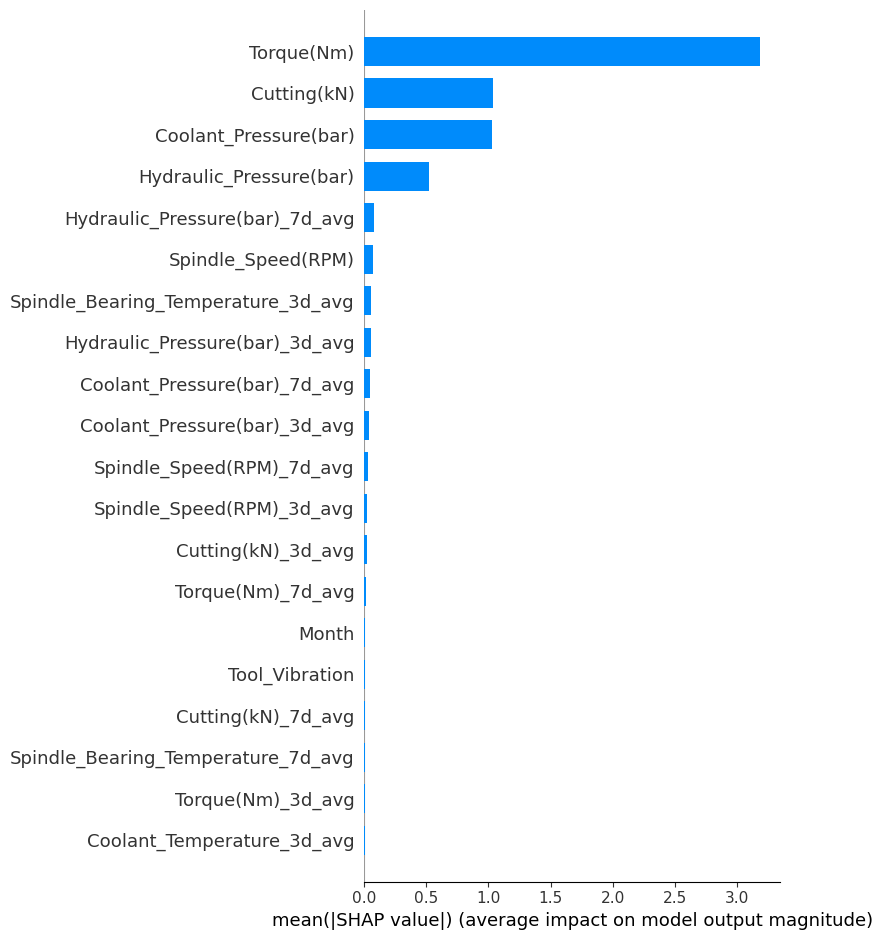

In [19]:
# SHAP analysis for feature importance for overall model
explainer_overall = shap.Explainer(gb_model, X_train)
shap_values_overall = explainer_overall(X_test)

# Plot SHAP summary plot for overall model
shap.summary_plot(shap_values_overall, X_test, plot_type="bar")

# Plot SHAP summary plot for overall model
#shap.summary_plot(shap_values_overall, X_test, show=False)
#plt.title("SHAP Summary Plot for Overall Model")
#plt.show()

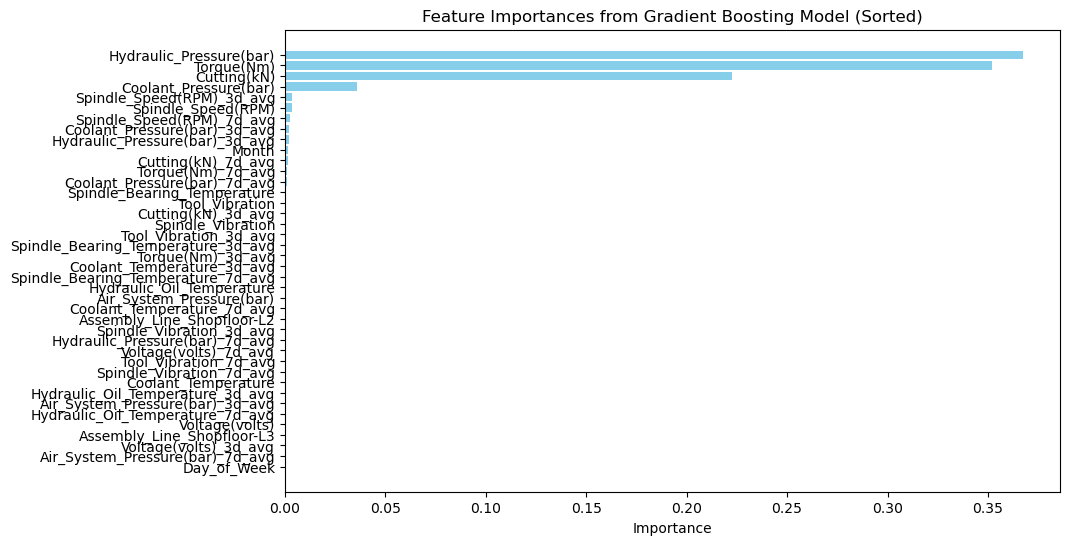

In [20]:
# Get feature importances from the best Gradient Boosting model
feature_importances = gb_model.feature_importances_

# Sort feature importances from most to least important
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = features.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot sorted feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Gradient Boosting Model (Sorted)')
plt.gca().invert_yaxis()
plt.show()

The most important features are **Hydraulic Pressure**, **Torque**, and **Cutting**; **Coolant Pressure** is a secondary feature

## Goal 3. Are your predictions more accurate if you model each machine separately?

In [21]:
df = pd.read_csv('data/machine_downtime.csv', parse_dates=['Date'], dayfirst=False)
df = df.dropna()

# One-hot encode the Assembly_Line_No feature
df = pd.get_dummies(df, columns=['Assembly_Line_No'], prefix='Assembly_Line', dtype='int', drop_first=True)

# Convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract temporal features from the Date column
df['Day_of_Week'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['Date'].dt.month

# Sort by Date to ensure rolling calculations are done in order
df.sort_values(by='Date', inplace=True)

# Calculate rolling averages for selected features (e.g., 3-day rolling average)
rolling_features = [
    'Hydraulic_Pressure(bar)', 'Coolant_Pressure(bar)', 'Air_System_Pressure(bar)',
    'Coolant_Temperature', 'Hydraulic_Oil_Temperature', 'Spindle_Bearing_Temperature',
    'Spindle_Vibration', 'Tool_Vibration', 'Spindle_Speed(RPM)',
    'Voltage(volts)', 'Torque(Nm)', 'Cutting(kN)'
]

for feature in rolling_features:
    df[f'{feature}_3d_avg'] = df[feature].rolling(window=3, min_periods=1).mean()
    df[f'{feature}_7d_avg'] = df[feature].rolling(window=7, min_periods=1).mean()

# Drop the original Date column since we have extracted all relevant temporal features
df.drop(columns=['Date'], inplace=True)

C:\Users\Brett Lill\AppData\Local\Temp\ipykernel_10020\634304754.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('data/machine_downtime.csv', parse_dates=['Date'], dayfirst=False)


In [22]:
# Compare performance for each machine separately
machine_ids = df['Machine_ID'].unique()
results = []

for machine_id in machine_ids:
    print(f"\nTraining model for Machine ID: {machine_id}")
    # Filter data for the specific machine
    machine_df = df[df['Machine_ID'] == machine_id]
    features = machine_df.drop(columns=[target, 'Machine_ID'])
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, machine_df[target], test_size=0.3, random_state=42, stratify=machine_df[target])

    # Train Gradient Boosting Classifier
    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train, y_train)
    
    # Make predictions with the Gradient Boosting model
    y_pred_gb = gb_model.predict(X_test)
    
    # Evaluate the Gradient Boosting model
    print('\nGradient Boosting Classification Report for Machine ID:', machine_id)
    report = classification_report(y_test, y_pred_gb, output_dict=True)
    print(classification_report(y_test, y_pred_gb))
    
    # Store results
    results.append({'Machine_ID': machine_id, 'f1_score': report['weighted avg']['f1-score']})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\nComparison of F1 Scores for Each Machine:")
print(results_df)

# Compare performance with an overall model
print("\nTraining overall model with all machines combined")
features_overall = df.drop(columns=[target, 'Machine_ID'])

# Split the overall dataset into training and testing sets
X_train_overall, X_test_overall, y_train_overall, y_test_overall = train_test_split(features_overall, df[target], test_size=0.3, random_state=42, stratify=df[target])

# Train Gradient Boosting Classifier for overall data
gb_model_overall = GradientBoostingClassifier(random_state=42)
gb_model_overall.fit(X_train_overall, y_train_overall)

# Make predictions with the overall Gradient Boosting model
y_pred_gb_overall = gb_model_overall.predict(X_test_overall)

# Evaluate the Gradient Boosting model for overall data
print('\nGradient Boosting Classification Report for Overall Model:')
overall_report = classification_report(y_test_overall, y_pred_gb_overall, output_dict=True)
print(classification_report(y_test_overall, y_pred_gb_overall))

# Add overall model results to the results DataFrame
results_df = pd.concat([results_df, pd.DataFrame([{'Machine_ID': 'Overall', 'f1_score': overall_report['weighted avg']['f1-score']}])], ignore_index=True)


Training model for Machine ID: Makino-L3-Unit1-2015

Gradient Boosting Classification Report for Machine ID: Makino-L3-Unit1-2015
                    precision    recall  f1-score   support

   Machine_Failure       0.98      0.97      0.98       123
No_Machine_Failure       0.97      0.98      0.97       114

          accuracy                           0.97       237
         macro avg       0.97      0.97      0.97       237
      weighted avg       0.97      0.97      0.97       237


Training model for Machine ID: Makino-L2-Unit1-2015

Gradient Boosting Classification Report for Machine ID: Makino-L2-Unit1-2015
                    precision    recall  f1-score   support

   Machine_Failure       1.00      0.97      0.98       115
No_Machine_Failure       0.97      1.00      0.98       114

          accuracy                           0.98       229
         macro avg       0.98      0.98      0.98       229
      weighted avg       0.98      0.98      0.98       229


Training mo

In [23]:
# Display final comparison
print("\nFinal Comparison of F1 Scores:")
print(results_df)


Final Comparison of F1 Scores:
             Machine_ID  f1_score
0  Makino-L3-Unit1-2015  0.974690
1  Makino-L2-Unit1-2015  0.982529
2  Makino-L1-Unit1-2013  0.991971
3               Overall  0.990212


## Conclusion

If your goal is to achieve the highest accuracy possible for each machine, **it is better to model each machine separately**, specifically in the case of **Makino-L1**, whose model had a higher F1 score that of the model trained on all the machines.

For the other two machine models, **Makino-L2 and Makino-L3**, their F1 scores were slightly below that of the overall model, suggesting that they share patterns with other machines that help the overall model generalize better.

Ultimately, if simplicity and ease of maintenance are priorities, and the trade-off resulting from the drop in accuracy is acceptable, using a single overall model may be an acceptable solution as the difference in F1 score between the overall model and the Makino-L1 model is not substantial.